In [1]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

import tensorflow
import tensorflow as tf
import pandas as pd 
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import time
import sys
%matplotlib inline
import random
import copy

random.seed(a=0)

class GeneticPool(object):
    def __init__(
        self, 
        populationSize = 8, 
        mutationRate = 0.1, 
        ins = None,
        outs = None):

        self.populationSize = populationSize
        self.mutationRate = mutationRate
        self.poolLR = [0.1, 0.5]
        self.poolInputNeurons = [16,20]
        self.poolHiddenLayer = [2,2.5]
        
    def generatePopulation(self):
        self.chromosomes = []
        for _ in range(self.populationSize):
            c = self.generateChromosome()
            self.chromosomes += [c]
                      
    def generateChromosome(self):
        class Chromosome:
            LR = random.uniform(self.poolLR[0], self.poolLR[1])
            InputNeurons = self.poolInputNeurons[random.randint(1,len(self.poolInputNeurons))-1]          
            HiddenLayer = self.poolHiddenLayer[random.randint(1,len(self.poolHiddenLayer))-1]
            Error = 0
            pesoEnt = []
            pesoSal = []
        chromosome = Chromosome() 
        return chromosome
    

In [2]:
class BackPropagation:
    def __init__(self, iteraciones, LR, neurons, window_size, prediction_size, train_size):
        iterations = iteraciones
        LR = LR
        neurons = int(neurons)
        window_size = int(window_size)
        prediction_size = prediction_size
        train_size = train_size
        #########################################################
        dat = pd.read_excel("1999-2018.xls", one_hot=True)
        data = (dat["Average"])
        #data = (validate_dat["Average"])    
        data = np.array(data)/np.max(data)
        data_size = (data.size)
        validate_size = data_size - train_size
        #########################################################
        a_0 = tf.placeholder(tf.float32, [1, window_size])
        y = tf.placeholder(tf.float32, [1, prediction_size])
        w_1 = tf.Variable(tf.truncated_normal([window_size, neurons]))
        w_2 = tf.Variable(tf.truncated_normal([neurons, prediction_size]))
        ##########################################################
        def sigma(x):
            return tf.div(tf.constant(1.0),
                          tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

        def sigmaprime(x):
            return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

        ##############################################################
        z_1 = tf.matmul(a_0, w_1)
        a_1 = sigma(z_1)
        z_2 = tf.matmul(a_1, w_2)
        a_2 = sigma(z_2)
        diff = tf.subtract(a_2, y)
        ###############################################################
        d_z_2 = tf.multiply(diff, sigmaprime(z_2))
        d_b_2 = d_z_2
        d_w_2 = tf.matmul(tf.transpose(a_1), d_z_2)
        d_a_1 = tf.matmul(d_z_2, tf.transpose(w_2))
        d_z_1 = tf.multiply(d_a_1, sigmaprime(z_1))
        d_b_1 = d_z_1
        d_w_1 = tf.matmul(tf.transpose(a_0), d_z_1)
        ###############################################################
        eta = tf.constant(LR)
        cost = tf.multiply(diff, diff)
        cost = tf.sqrt(cost)
        #step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
        step = [
            tf.assign(w_1,
                    tf.subtract(w_1, tf.multiply(eta, d_w_1)))
          , tf.assign(w_2,
                    tf.subtract(w_2, tf.multiply(eta, d_w_2)))
        ]
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        df = pd.DataFrame(columns=['error'])
        comp1=0
        ##############################################################################################
        for i in range(iterations):
            error_final = 0
            for j in range ((train_size - prediction_size) - window_size):
                batch_xs = (data[j: j+window_size])
                batch_ys = (data[j+window_size ])
                batch_xs = np.reshape(batch_xs,(1,window_size))
                batch_ys = np.reshape(batch_ys,(1,1))
                sess.run([step,cost], feed_dict = {a_0: batch_xs, y : batch_ys})
            for j in range (12):
                ss = 12
                batch_xs = (data[train_size - window_size +j: train_size +j])
                batch_ys = (data[train_size + j])
                batch_xs = np.reshape(batch_xs,(1,window_size))
                batch_ys = np.reshape(batch_ys,(1,1))
                error,rediff,w1,w2 = sess.run([cost,a_2,w_1,w_2], feed_dict = {a_0: batch_xs, y : batch_ys})
                error_final += error[0][0]
            lis =[]
            for j in range(len(w2)):
                lis.append(w2[j][0])
            index = np.arange(len(lis))
            plt.figure(i)
            plt.bar(index,lis)
            plt.savefig('pesos.png')
            plt.show()
            plt.close()
            if(i==0):
                comp1=error_final/ss
                df.append({'error':error_final/ss}, ignore_index=True)
                self.final_result = error_final/ss
            else:
                if(comp1<error_final/ss):
                    break
                else:
                    comp1=error_final/ss
                    df.append({'error':error_final/ss}, ignore_index=True)
                    self.rediff = rediff
                    self.final_result = error_final/ss
        self.resultado = df
        self.pesosEnt = w1
        self.pesosHid = w2
        sess.close()

In [3]:
def StartGenetic():
    a = GeneticPool()
    a.generatePopulation()
    listIndex = []
    for i in range (len(a.chromosomes)):
        b = BackPropagation (20,a.chromosomes[i].LR,int(a.chromosomes[i].HiddenLayer*(a.chromosomes[i].InputNeurons)), int(a.chromosomes[i].InputNeurons), 1, 216)
        #b.resultado.plot()
        a.chromosomes[i].Error = b.final_result
    return a.chromosomes

def Fitness(num, obj):
    listIndex = []   
    for i in range (len(obj)):
        if i == 0:
            listIndex = [i]
        elif len(listIndex) <= num -1 :
            if obj[listIndex[len(listIndex)-1]].Error <= obj[i].Error:
                listIndex.append(i)
            else :
                for j in range (len(listIndex),-1,-1):
                    if j == 0:
                        listIndex.insert(0,i)
                        break
                        
                    elif obj[listIndex[j-1]].Error <= obj[i].Error:
                        listIndex.insert(j,i)
                        break
        else :
            if obj[listIndex[len(listIndex)-1]].Error >= obj[i].Error:
                for j in range (len(listIndex),-1,-1):
                    if j == 0:
                        listIndex.insert(0,i)
                        listIndex.pop()
                        break
                        
                    elif obj[listIndex[j-1]].Error <= obj[i].Error:
                        listIndex.insert(j,i)  
                        listIndex.pop()
                        break
    matingPool = []
    for i in listIndex:
        matingPool.append(obj[i])
    return matingPool
        
        
        

In [4]:
def swap(w1,w2):
    mutation = 0.1
    poolLR = [0.1, 0.5]
    poolInputNeurons = [16,20]
    poolHiddenLayer = [2,2.5]
    children = copy.deepcopy(w1)
    r = random.randint(0,1)
    if r == 0:
        children.HiddenLayer = w2.HiddenLayer
    else :
        children.LR = w2.LR
        children.InputNeurons = w2.InputNeurons
    
    for i in range(3):
        valor = random.uniform(0,1)
        if  valor < mutation:
            if (i  == 0):
                children.HiddenLayer = poolHiddenLayer[random.randint(0, len(poolHiddenLayer)-1)]
            elif (i == 1):
                children.LR = random.uniform(poolLR[0], poolLR[1])
            else:
                children.InputNeurons = poolInputNeurons[random.randint(0,len(poolInputNeurons)-1)]
                
    return children

def CrossOver(matingPool,population):
    
    percentage = []
    total_error = 0
    suma = 0
    roulette = []
    newGeneration = []
    
    for i in matingPool:
        percentage.append(1/i.Error)
        total_error += 1/i.Error
    for i in range(len(matingPool)):
        percentage[i] = round((percentage[i]/total_error)*100)
    
    for i in percentage:
        suma += i
    
    if suma > 100:
        percentage[len(percentage)-1] -= suma - 100
    
    elif suma < 100:
        percentage[0] += 100 - suma

    
    var = 0
    for i in percentage:
        for j in range (int(i)):
            roulette.append(matingPool[var])
        var += 1
    
    print(1, matingPool[0].LR,matingPool[1].LR)
    for i in range(population):
        winner1 = random.randint(0,len(roulette)-1)
        winner2 = winner1
        while (winner2 == winner1):
            winner2 = random.randint(0,len(roulette)-1)
        #print(2, matingPool[0].LR,matingPool[1].LR)
        newGeneration.append(swap(roulette[winner1],roulette[winner2]))
    return newGeneration

    
    

In [5]:

def main ():
    x = StartGenetic()
    b = Fitness(5,x)
    fg=x
    z = CrossOver(b,8)
    for epocas in range (2):
        for i in z:
            er = BackPropagation(20,i.LR,int(i.HiddenLayer*(i.InputNeurons)),int(i.InputNeurons),1,216)
            i.Error = er.final_result
            i.pesoEnt = er.pesosEnt
            i.pesoSal = er.pesosHid
            #print(i.pesoSal)
        b = Fitness(5,z)
        #print(vars(b[0]))
        z = CrossOver(b,8)
    return z

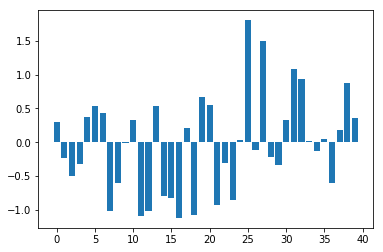

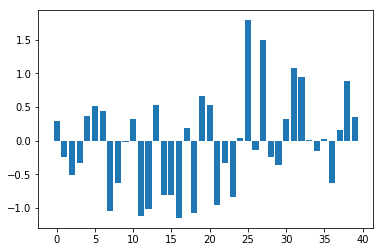

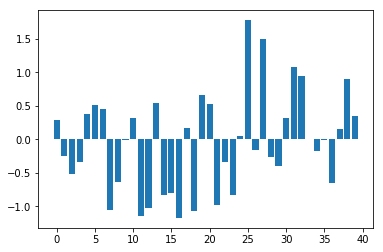

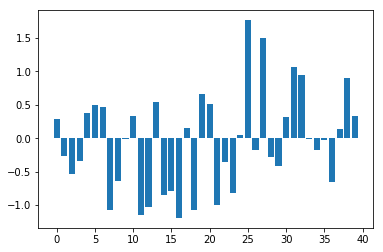

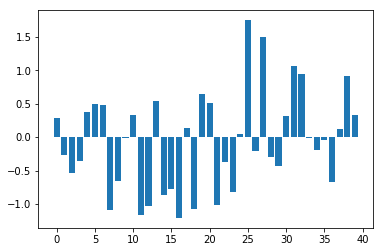

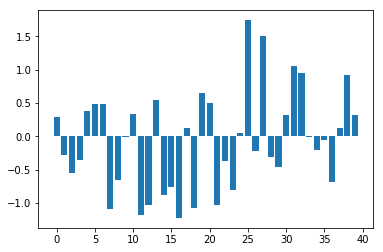

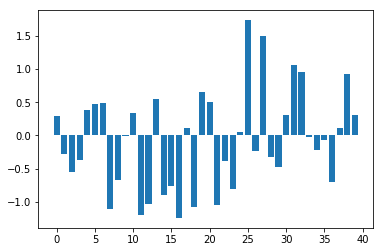

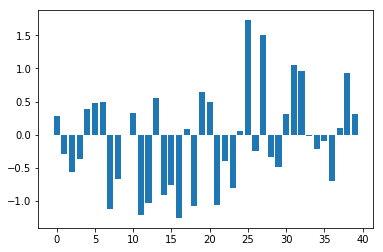

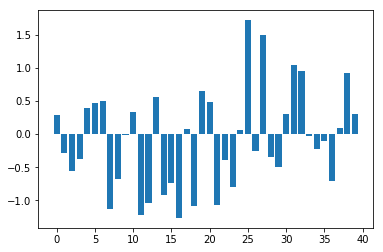

KeyboardInterrupt: 

In [6]:
BackPropagation(20, 0.247295355366197,2.5*16,3,1,180)

In [ ]:
z = main()
#z = Fitness(5,z)



In [ ]:
vars(z[0])

In [ ]:
        lis =[]
        for j in range(len(b[0].pesoSal)):
            lis.append(b[0].pesoSal[j][0])
        index = np.arange(len(lis))
        plt.figure(epocas)
        plt.bar(index,lis)

In [ ]:
class ValidateBP:
    def __init__(self, iteraciones, LR, neurons, window_size, dataRetoque, dataSalida, pesoEntrada, pesoEscondido, training):
        iterations = iteraciones
        LR = LR
        neurons = int(neurons)
        window_size = int(window_size)
        pesoEnt = pesoEntrada
        pesoHid = pesoEscondido
        dataRetoque = dataRetoque
        dataSalida = dataSalida
        training =  training

        #########################################################
        a_0 = tf.placeholder(tf.float32, [1, 16])
        y = tf.placeholder(tf.float32, [1, 1])
        w_1 =  tf.Variable(pesoEntrada)
        w_2 =  tf.Variable(pesoEscondido)
        ##########################################################
        def sigma(x):
            return tf.div(tf.constant(1.0),
                          tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))

        def sigmaprime(x):
            return tf.multiply(sigma(x), tf.subtract(tf.constant(1.0), sigma(x)))

        ##############################################################
        z_1 = tf.matmul(a_0, w_1)
        a_1 = sigma(z_1)
        z_2 = tf.matmul(a_1, w_2)
        a_2 = sigma(z_2)
        diff = tf.subtract(a_2, y)
        ###############################################################
        d_z_2 = tf.multiply(diff, sigmaprime(z_2))
        d_b_2 = d_z_2
        d_w_2 = tf.matmul(tf.transpose(a_1), d_z_2)
        d_a_1 = tf.matmul(d_z_2, tf.transpose(w_2))
        d_z_1 = tf.multiply(d_a_1, sigmaprime(z_1))
        d_b_1 = d_z_1
        d_w_1 = tf.matmul(tf.transpose(a_0), d_z_1)
        ###############################################################
        eta = tf.constant(LR)
        cost = tf.multiply(diff, diff)
        cost = tf.sqrt(cost)
        #step = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
        step = [
            tf.assign(w_1,
                    tf.subtract(w_1, tf.multiply(eta, d_w_1)))
          , tf.assign(w_2,
                    tf.subtract(w_2, tf.multiply(eta, d_w_2)))
        ]
        sess = tf.InteractiveSession()
        sess.run(tf.global_variables_initializer())
        df = pd.DataFrame(columns=['error'])
        comp1=0
        ##############################################################################################
        if (training):
            for i in range(iterations):
                error_final = 0
                batch_xs = dataRetoque
                batch_ys = dataSalida
                batch_xs = np.reshape(batch_xs,(1,16))
                batch_ys = np.reshape(batch_ys,(1,1))
                a,w1,w2 = sess.run([step,w_1,w_2], feed_dict = {a_0: batch_xs, y : batch_ys})
                pesoEntrada = w_1
                pesoEscondido = w_2
            self.pesoEntrada = pesoEntrada.eval()
            self.pesoEscondido = pesoEscondido.eval()
        else:
            error_final = 0
            batch_xs = dataRetoque
            batch_ys = dataSalida
            batch_xs = np.reshape(batch_xs,(1,16))
            batch_ys = np.reshape(batch_ys,(1,1))
            a = sess.run([a_2], feed_dict = {a_0: batch_xs, y : batch_ys})
            self.salida = a
        sess.close()

In [ ]:
def  llenarData(pesoEntrada2,pesoEscondido2):
    pesoEntrada = tf.Variable(pesoEntrada2)
    pesoEscondido = tf.Variable(pesoEscondido2)
    data = pd.read_excel("4years-2013-2017.xls", one_hot=True)
    data = (data["Average"])
    data = np.array(data)/np.max(data)
    valores = []
    valoresVer =[]
    for i in range(len(data) - 17):
        dataRetoque = data[i:i+16]
        dataSalida = data[i+16]
        newBP =ValidateBP(50,0.3014546020839549, 2*16, 16, dataRetoque, dataSalida, pesoEntrada, pesoEscondido, True)
        pesoEntrada=newBP.pesoEntrada
        pesoEscondido=newBP.pesoEscondido
        dataRetoque = data[i+1:i+17]
        dataSalida = data[i+17]
        salida = ValidateBP(50,00.3014546020839549, 2*16, 16, dataRetoque, dataSalida, pesoEntrada, pesoEscondido, False).salida
        valores.append(salida[0][0][0])
        valoresVer.append(dataSalida)
        print(i)
    return valores, valoresVer

In [ ]:
a, b  = llenarData(z[0].pesoEnt,z[0].pesoSal)
a = pd.DataFrame({'Prediccion':a})
b = pd.DataFrame({'Real':b})
data = pd.read_excel("4years-2013-2017.xls", one_hot=True)
data = (data["Average"])
maxi = np.max(data)
a = a * maxi
b = b * maxi
c = pd.concat([a,b], axis = 1)
c.plot()

In [ ]:
b = a['Predicción']
lista = []
for i in b:
    lista.append((i[0][0][0]))


In [ ]:
lista2 = pd.DataFrame({'prediction':lista})
lista2.plot()


In [ ]:
 intento = ValidateBP(20, 0.247295355366197,2.5*16,3,1,12,forGraph.pesosEnt, forGraph.pesosHid)

In [ ]:
vars(intento)

In [ ]:
z2 = Fitness(5,z)

In [ ]:
vars(z2[2])

In [ ]:
#2.5 20 0.012368505258660532
forGraph=BackPropagation(20, 0.247295355366197,2.5*16,3,1,180)

In [ ]:
vars(forGraph)

In [ ]:
#precioBarril = pd.read_excel("precioBarril.xls")
#data = (precioBarril["Average"])
#print(np.max(data))

# forGraph.resultado.plot()


In [ ]:
forGraph.resultado.plot()

In [ ]:
#print(0.170855*117.4)
#print((0.168914794921875)/26)
#print(81.730599844-61.9)

In [ ]:
i = [1]
i.append(2)
i